# Homework 4

## ASTR 5900, Fall 2020

### KMeans and PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Problem 1

### Part A

Load the Old Faithful data (remember this?) from http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat.  

A standard procedure in problems with multi-dimensional data is to standardize the data, or give each dimension the same scaling.  It is common to make every parameter distributed around 0 with a standard variance.  That is, find a new data set with parameters $y_{i}^{(j)}$ where:

$$ y_{i}^{(j)} = \frac{x_{i}^{(j)} - \mu^{(j)}}{\sigma^{(j)}}$$

Here $x_{i}^{(j)}$ is the $i$th data point in the $j$th dimension.

Transform the Old Faithful Data in this manner.

In [2]:
# (duration of eruption, time between eruptions)
fn = '../hw1/faithful.dat'
data = np.loadtxt(fn, usecols=(1, 2), skiprows=26)

mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
scaled_data = (data - mean) / std

### Part B

Use `sklearn.cluster.KMeans` to split the Old Faithful data into 2 clusters.  Plot the data with each point colored according to its cluster label.  Also plot the centers of the clusters, and make them distuinguishable from the data.

Read more at http://scikit-learn.org/stable/modules/density.html.  Consider looking at the examples on the `scikit-learn` website and the lecture.

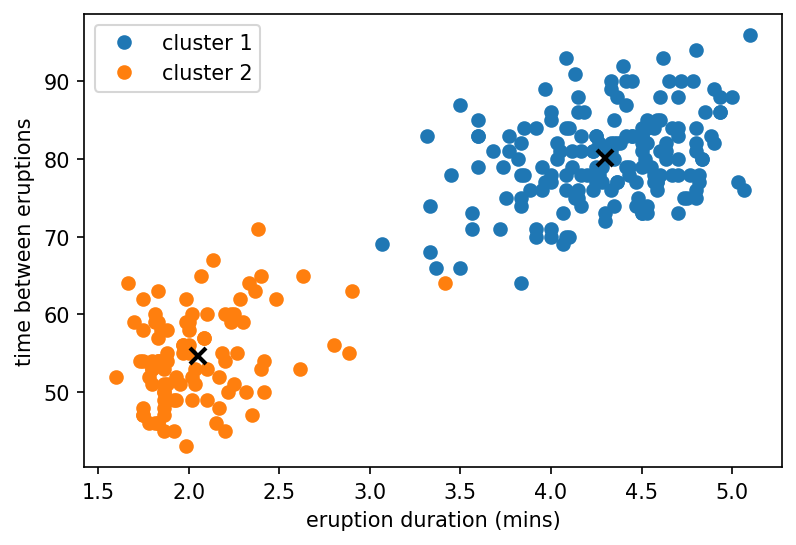

In [3]:
n_components = 2
kmeans = KMeans(n_components)
kmeans.fit(scaled_data)

fig, ax = plt.subplots(dpi=150)

# I am purposefully plotting the physical data and not the scaled data
for i in range(n_components):
    mask = kmeans.labels_ == i
    ax.plot(data[:, 0][mask], data[:, 1][mask], 'o', label=f'cluster {i + 1}', zorder=0)
    
    center = std * kmeans.cluster_centers_[i] + mean
    ax.plot(*center, 'x', mew=2, ms=8, c='k', zorder=1)

ax.set_xlabel('eruption duration (mins)')
ax.set_ylabel('time between eruptions')
    
ax.legend()

plt.show()

### Part C

Code from scratch (that is, with default python and numpy only) your own k-means clustering algorithm to split the Old Faithful data into 2 clusters.  Refer to the lecture and a section from the Bishop textbook on canvas titled *Bishop9-1.pdf*.  Figure 9.1 in the text is particularly informative.

In [4]:
class myKMeans:

    def __init__(self, n_components):
        self.n_components = n_components
        
        self.cluster_centers = None
        self.labels = None
        
    def _init_centers(self, X):
        n_dim = X.shape[1]
        n_comp = self.n_components
        _min = X.min(axis=0)
        _max = X.max(axis=0)
        
        centers = np.empty((n_comp, n_dim))
        
        for m in range(n_dim):
            centers[:, m] = np.random.uniform(_min[m], _max[m], n_comp)
            
        return centers

    def _get_closest(self, X, centers):
        n = X.shape[0]
        n_comp = self.n_components

        dists = np.empty((n, n_comp))
        for k in range(n_comp):
            vectors = X - centers[k]
            dists[:, k] = (vectors * vectors).sum(axis=1)
        labels = dists.argmin(axis=1)
        
        return labels

    def _kmeans_single(self, X, centers):
        n = X.shape[0]
        n_comp = self.n_components

        labels = self._get_closest(X, centers)
        
        r = np.zeros((n, n_comp))
        for k in range(n_comp):
            mask = labels == k
            r[mask == 1, k] = np.ones(mask.sum())
        
        new_centers = (r.T @ X).T / r.sum(axis=0)
        new_centers = new_centers.T
        
        return new_centers
    
    def fit(self, X, max_iter=100):
        n_comp = self.n_components
        
        prev_centers = self._init_centers(X)
        
        for _ in range(max_iter):
            centers = self._kmeans_single(X, prev_centers)
            if np.array_equal(centers, prev_centers):
                break
            else:
                prev_centers = centers
        else:
            print('max iteration achieved, did not converge')
        
        self.cluster_centers = centers
        self.labels = self._get_closest(X, centers)
        
        return self

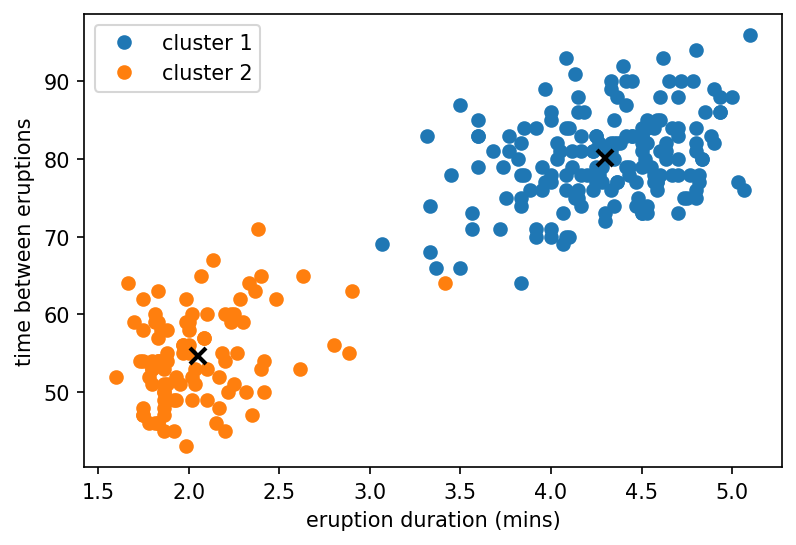

In [5]:
kmeans = myKMeans(n_components)
kmeans.fit(scaled_data)

fig, ax = plt.subplots(dpi=150)

# I am purposefully plotting the true data and not the scaled data
for i in range(n_components):
    mask = kmeans.labels == i
    ax.plot(data[:, 0][mask], data[:, 1][mask], 'o', label=f'cluster {i + 1}', zorder=0)
    
    center = std * kmeans.cluster_centers[i] + mean
    ax.plot(*center, 'x', mew=2, ms=8, c='k', zorder=1)

ax.set_xlabel('eruption duration (mins)')
ax.set_ylabel('time between eruptions')

ax.legend()

plt.show()

# Problem 2

### Part A

Load data from canvas titled `spins.txt`.  This is a set of classical spin configurations on a 2D square lattice sampled with Monte Carlo.  The first column contains the temperature at which the configuration was sampled.  The remaining 400 points (its a $20 \times 20$ lattice) correspond to the measured spin, either up or down, on particular lattice sites.  There are 10,000 data points in total.  It is not necessary to preprocess the data.

Perform PCA on the spin data.  Since PCA is an unsupervised machine learning method, by definition labels are not used to train the model.  Let's treat the temperature as labels, so train PCA solely on the spin part of the data.  You can do PCA through your method of choice (e.g. `sklearn`, diagonalizing the covariance yourself with `numpy`, etc.)

In [6]:
fn = 'spins.txt'
data = np.loadtxt(fn)
T = data[:, 0]
spin = data[:, 1:]

In [7]:
pca = PCA().fit(spin)

### Part B

Plot the resulting fractional variance of the principal components.  Briefly describe what you see.

Inspect the relevant principal components.  If you plot the components, be mindful of the way `matplotlib` will automatically scale plots.  Discuss the components: how do you interpret them?

> We see from the fractional variance plot that ~48% of the variance is explained by the first PC, and afterward the PCs begin to only explain ~1% of the variance, or much less. I decided that the only relevant components are the first five that explain at least 1% of the variance.

> Being so dominant in terms of explained variance, I would interpret the first eigenvector as a mean spin value that the configuration may have at each site. The other PCs just seem to be a group of sinusoidal vectors that add up to fit the data best (e.g. a Fourier series).

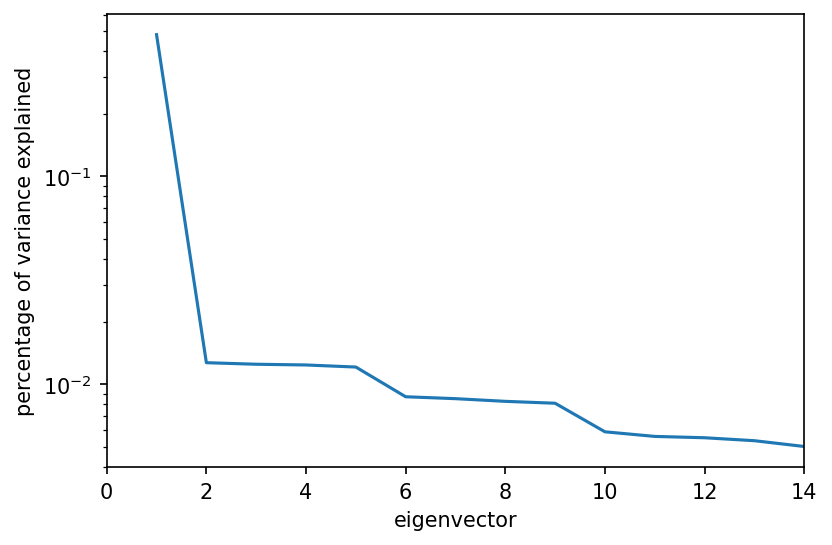

In [8]:
var_ratio = pca.explained_variance_ratio_

fig, ax = plt.subplots(dpi=150)

eig = np.arange(1, len(var_ratio) + 1)
mask = var_ratio > 0.005
ax.plot(eig[mask], var_ratio[mask])

ax.set_yscale('log')
ax.set_xlim(0, mask.sum())
ax.set_xlabel('eigenvector')
ax.set_ylabel('percentage of variance explained')

plt.show()

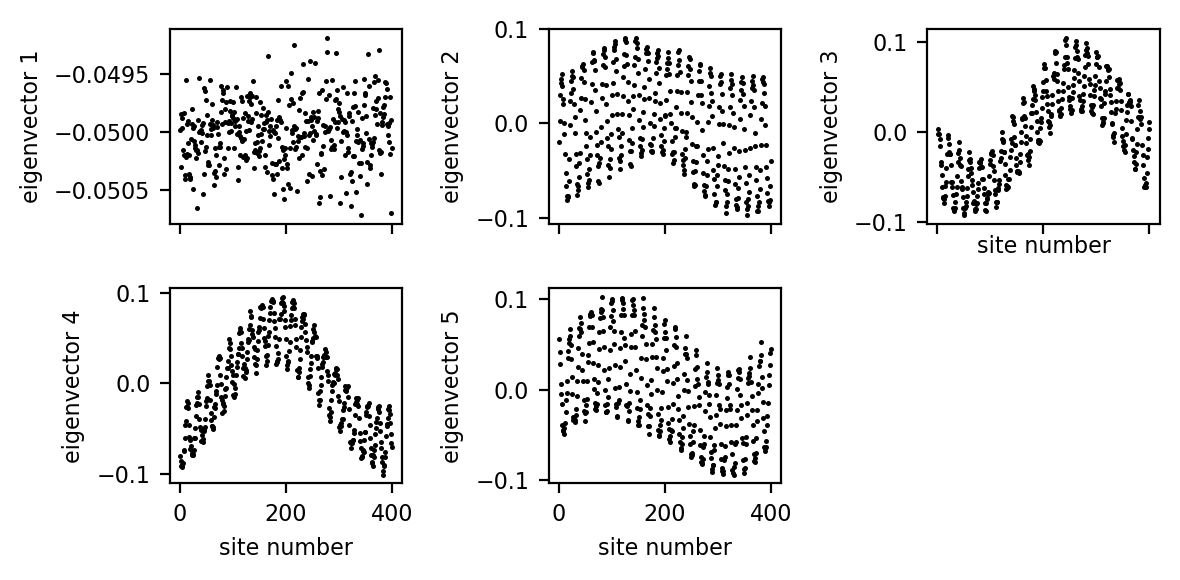

In [9]:
comp = pca.components_
sites = np.arange(1, 401)

def plot_comp(ind, axis):
    axis.plot(sites, comp[ind], 'ko', ms=0.8)
    axis.set_ylabel(f'eigenvector {ind + 1}', fontsize=8)
    axis.tick_params('both', labelsize=8)

fig, ax = plt.subplots(2, 3, dpi=200, figsize=(6, 3), sharex=True)

[plot_comp(*_ax) for _ax in enumerate(ax.ravel()[:-1])]

ax[1, 0].set_xlabel('site number', fontsize=8)
ax[1, 1].set_xlabel('site number', fontsize=8)
ax[0, 2].set_xlabel('site number', fontsize=8)

ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

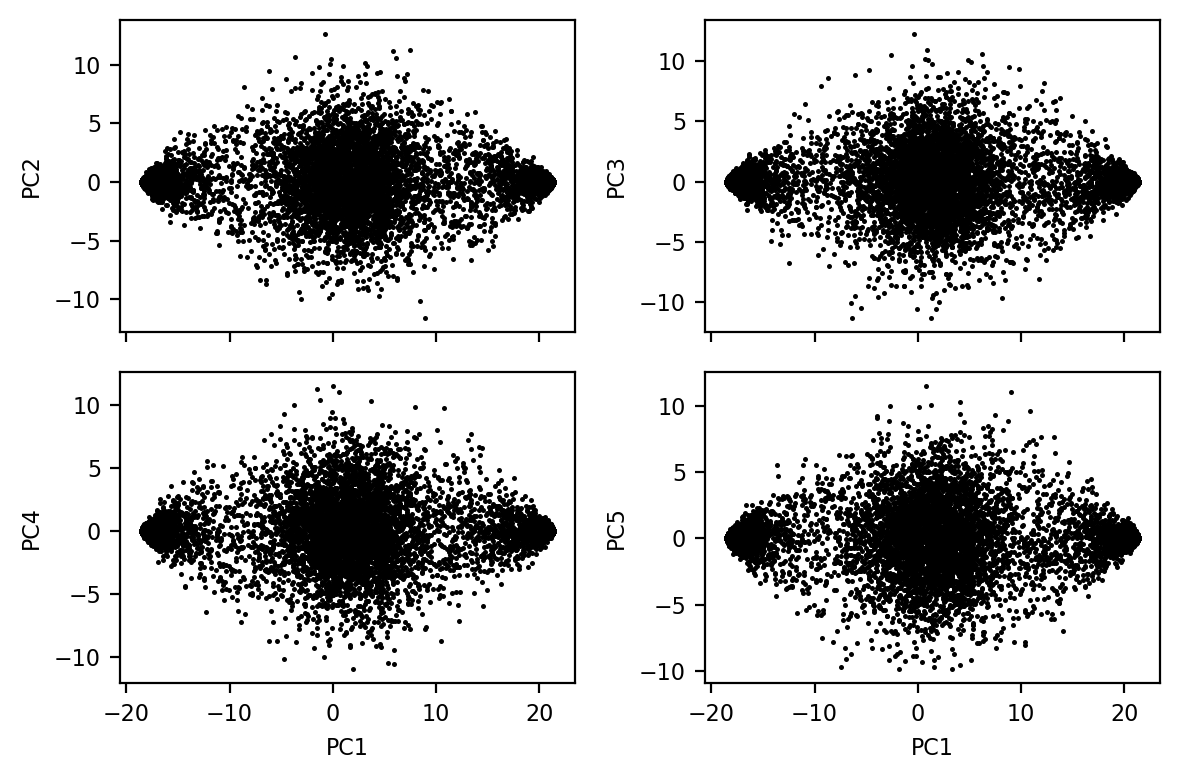

In [10]:
pc = pca.transform(spin)

def plot_PC(ind, axis):
    axis.plot(pc[:, 0], pc[:, ind + 1], 'ko', ms=0.8)
    axis.set_ylabel(f'PC{ind + 2}', fontsize=8)
    axis.tick_params('both', labelsize=8)

fig, ax = plt.subplots(2, 2, dpi=200, sharex=True)

[plot_PC(*_ax) for _ax in enumerate(ax.ravel())]

[ax[1, i].set_xlabel('PC1', fontsize=8) for i in range(2)]

plt.tight_layout()
plt.show()

### Part C

Plot the data in terms of the 1st and 2nd principal components.  Remember the temperatures we ignored during PCA?  When you plot this data, color every point based on the temperature in which it was sampled.  You can call `matplotlib.pyplot.colorbar` to automatically draw a color legend.  Briefly describe what you see.

> We immediately see that temperature is dependent mostly on just PC1, where the temperature is highest near PC1 = 0, and the temperature is lower as |PC1| increases.

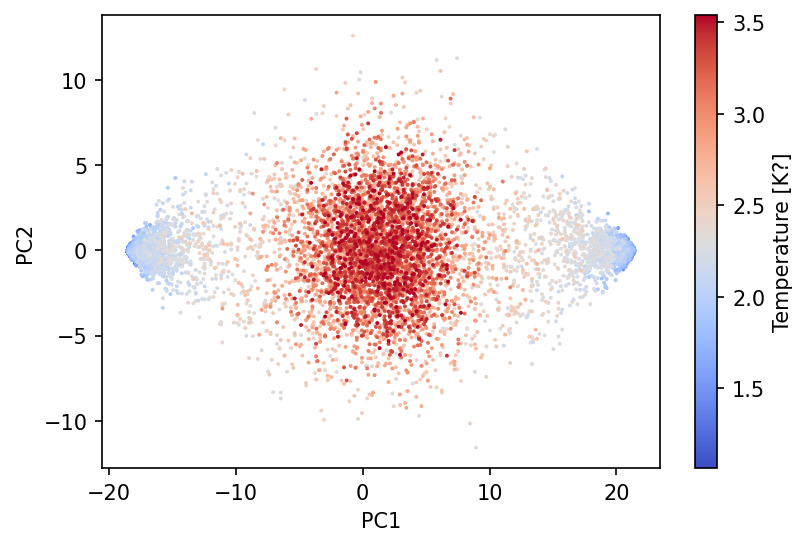

In [11]:
fig, ax = plt.subplots(dpi=150)

sc = ax.scatter(pc[:, 0], pc[:, 1], marker='o', s=0.8, c=T,
                cmap='coolwarm')
fig.colorbar(sc, ax=ax, label='Temperature [K?]')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.show()

### Part D

Lastly, discuss your trained model and its physical ramifications.  Specifically address these points:

- What does the 1st principal component correspond to, physically?

- In the context of PCA, what effect does temperature have on the data?  Is this a gradual change of the data, or a sudden change?

- Why do you see 3 clusters in the transformed data?  I could also ask, why DON'T you see only 2?

> The 1st principal component corresponds to the average/expected spin value for the system. As is seen in the plot, this is related to temperature in the following way. If, for example, the value on the PC1 axis of your configuration is around 0, then on average half the sites will be +1 and the other half will be -1. If that is the case, you will have more 50/50 spin states available than the other way around, with most sites being either +1 or -1. In that case, there are fewer configurations available that will yield a large |PC1| value. With more states available, the system will be a higher temperature, and this is illustrated in the plot. The temperature conversely changes the average spin value, and it happens quite suddenly, according to the plot.

> Finally, we see 3 clusters here instead of 2 because there is not only a netural (zero-average) spin state as well as two extremes going 1. all in the +1 direction and 2. in the -1 direction.